In [10]:
import pandas as pd
import numpy as np

# ---- Load data ----
daily = pd.read_csv("../data/daily_kpis.csv")
funnel = pd.read_csv("../data/funnel_summary.csv")
device = pd.read_csv("../data/device_conversion.csv")

# ---- Basic cleanup ----
daily["event_date"] = pd.to_datetime(daily["event_date"])
daily = daily.sort_values("event_date").reset_index(drop=True)

# ---- Quick validation prints ----
print("daily shape:", daily.shape)
print("funnel shape:", funnel.shape)
print("device shape:", device.shape)

print("\nDaily columns:", daily.columns.tolist())
print("Funnel columns:", funnel.columns.tolist())
print("Device columns:", device.columns.tolist())

# ---- Check conversion rate sanity (should be 0-1) ----
print("\nDaily conversion range:", daily["daily_conversion_rate"].min(), "to", daily["daily_conversion_rate"].max())
print("Device conversion range:", device["conversion_rate"].min(), "to", device["conversion_rate"].max())

# ---- Compute headline KPIs (for reference) ----
total_revenue = daily["daily_revenue"].sum()
total_users_entry = int(funnel.loc[0, "viewed"])
total_purchasers = int(funnel.loc[0, "purchased"])
overall_conversion = total_purchasers / total_users_entry
aov = total_revenue / total_purchasers

print("\n--- Headline KPIs ---")
print(f"Total Revenue: ${total_revenue:,.0f}")
print(f"Funnel Entry Users (Viewed): {total_users_entry:,}")
print(f"Purchasers: {total_purchasers:,}")
print(f"Overall Conversion: {overall_conversion:.2%}")
print(f"Average Order Value (AOV): ${aov:,.2f}")

daily shape: (92, 5)
funnel shape: (1, 4)
device shape: (3, 4)

Daily columns: ['event_date', 'daily_users', 'daily_revenue', 'daily_purchasers', 'daily_conversion_rate']
Funnel columns: ['viewed', 'added_to_cart', 'began_checkout', 'purchased']
Device columns: ['device_type', 'users', 'purchasers', 'conversion_rate']

Daily conversion range: 0.0251450676982591 to 0.1225697379543533
Device conversion range: 0.0670816044260027 to 0.0744989133059647

--- Headline KPIs ---
Total Revenue: $362,165
Funnel Entry Users (Viewed): 61,252
Purchasers: 4,419
Overall Conversion: 7.21%
Average Order Value (AOV): $81.96


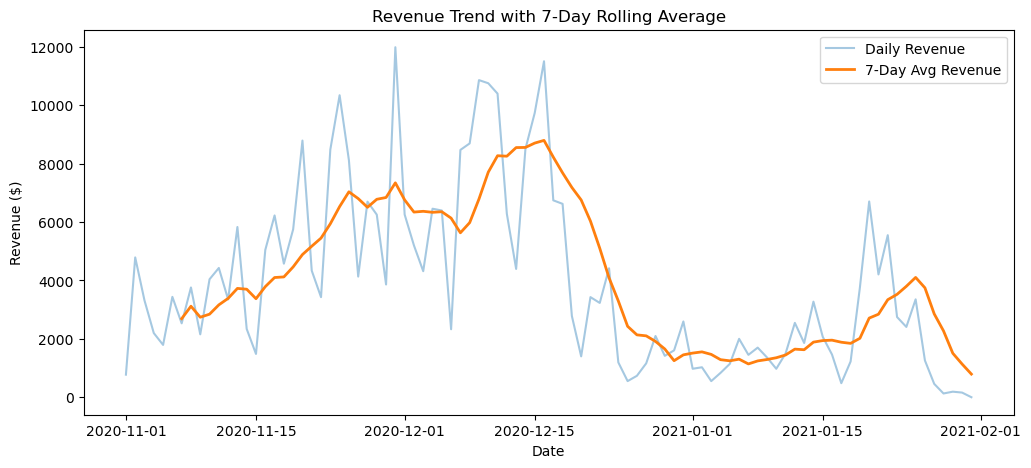

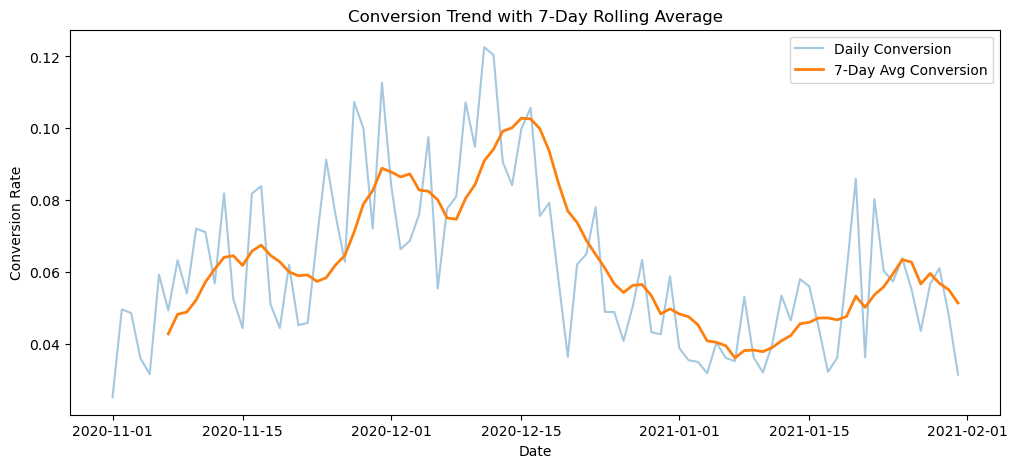

In [11]:
import matplotlib.pyplot as plt

# ---- Create rolling averages ----
daily["revenue_7d_avg"] = daily["daily_revenue"].rolling(window=7).mean()
daily["conversion_7d_avg"] = daily["daily_conversion_rate"].rolling(window=7).mean()

# ---- Plot Revenue Trend ----
plt.figure(figsize=(12,5))
plt.plot(daily["event_date"], daily["daily_revenue"], alpha=0.4, label="Daily Revenue")
plt.plot(daily["event_date"], daily["revenue_7d_avg"], linewidth=2, label="7-Day Avg Revenue")
plt.title("Revenue Trend with 7-Day Rolling Average")
plt.xlabel("Date")
plt.ylabel("Revenue ($)")
plt.legend()
plt.show()

# ---- Plot Conversion Trend ----
plt.figure(figsize=(12,5))
plt.plot(daily["event_date"], daily["daily_conversion_rate"], alpha=0.4, label="Daily Conversion")
plt.plot(daily["event_date"], daily["conversion_7d_avg"], linewidth=2, label="7-Day Avg Conversion")
plt.title("Conversion Trend with 7-Day Rolling Average")
plt.xlabel("Date")
plt.ylabel("Conversion Rate")
plt.legend()
plt.show()

In [12]:
# --- Daily AOV (Revenue per purchaser) ---
daily["daily_aov"] = daily["daily_revenue"] / daily["daily_purchasers"]

# --- Revenue driver decomposition ---
# Revenue ≈ Users * Conversion Rate * AOV
daily["revenue_reconstructed"] = (
    daily["daily_users"] *
    daily["daily_conversion_rate"] *
    daily["daily_aov"]
)

# --- Correlation analysis ---
correlation_matrix = daily[[
    "daily_revenue",
    "daily_users",
    "daily_conversion_rate",
    "daily_aov"
]].corr()

correlation_matrix

,daily_revenue,daily_users,daily_conversion_rate,daily_aov
daily_revenue,1.000000,0.737470,0.835172,0.600162
daily_users,0.737470,1.000000,0.588591,0.198704
daily_conversion_rate,0.835172,0.588591,1.000000,0.278598
daily_aov,0.600162,0.198704,0.278598,1.000000


In [13]:
# ---- Identify peak week (mid December) ----
peak_period = daily[(daily["event_date"] >= "2020-12-07") & 
                    (daily["event_date"] <= "2020-12-20")]

post_period = daily[(daily["event_date"] >= "2021-01-05") & 
                    (daily["event_date"] <= "2021-01-20")]

# ---- Calculate averages ----
peak_avg = peak_period[["daily_revenue","daily_users","daily_conversion_rate","daily_aov"]].mean()
post_avg = post_period[["daily_revenue","daily_users","daily_conversion_rate","daily_aov"]].mean()

comparison = pd.DataFrame({
    "Peak Period Avg": peak_avg,
    "Post-Holiday Avg": post_avg,
    "Absolute Change": post_avg - peak_avg,
    "% Change": (post_avg - peak_avg) / peak_avg
})

comparison

,Peak Period Avg,Post-Holiday Avg,Absolute Change,% Change
daily_revenue,7654.785714,2094.000000,-5560.785714,-0.726446
daily_users,1022.142857,670.812500,-351.330357,-0.343719
daily_conversion_rate,0.088076,0.046600,-0.041476,-0.470909
daily_aov,81.541839,61.235153,-20.306686,-0.249034


In [14]:
# --- Decomposition approximation ---
# Revenue = Users × Conversion × AOV

# Baseline peak values
U0 = peak_avg["daily_users"]
C0 = peak_avg["daily_conversion_rate"]
A0 = peak_avg["daily_aov"]

# Post values
U1 = post_avg["daily_users"]
C1 = post_avg["daily_conversion_rate"]
A1 = post_avg["daily_aov"]

# Calculate effect of each change individually
revenue_base = U0 * C0 * A0

revenue_users_only = U1 * C0 * A0
revenue_conversion_only = U0 * C1 * A0
revenue_aov_only = U0 * C0 * A1

print("Revenue at Peak:", revenue_base)
print("Revenue if only Users changed:", revenue_users_only)
print("Revenue if only Conversion changed:", revenue_conversion_only)
print("Revenue if only AOV changed:", revenue_aov_only)

Revenue at Peak: 7340.943723157304
Revenue if only Users changed: 4817.718753184236
Revenue if only Conversion changed: 3884.0300433169564
Revenue if only AOV changed: 5512.799520331408


In [15]:
# --- Funnel Drop Analysis ---

viewed = funnel.loc[0, "viewed"]
added_to_cart = funnel.loc[0, "added_to_cart"]
began_checkout = funnel.loc[0, "began_checkout"]
purchased = funnel.loc[0, "purchased"]

view_to_cart = added_to_cart / viewed
cart_to_checkout = began_checkout / added_to_cart
checkout_to_purchase = purchased / began_checkout
overall_conversion = purchased / viewed

funnel_analysis = pd.DataFrame({
    "Stage Conversion Rate": [
        view_to_cart,
        cart_to_checkout,
        checkout_to_purchase,
        overall_conversion
    ]
}, index=[
    "View → Cart",
    "Cart → Checkout",
    "Checkout → Purchase",
    "Overall Funnel"
])

funnel_analysis

,Stage Conversion Rate
View → Cart,0.204810
Cart → Checkout,0.774412
Checkout → Purchase,0.454864
Overall Funnel,0.072145


In [16]:
# --- Device Contribution Impact Model ---

# Current totals
total_users = device["users"].sum()
total_revenue = daily["daily_revenue"].sum()

# Current weighted conversion
weighted_conversion = (
    (device["users"] * device["conversion_rate"]).sum() / total_users
)

print("Current Weighted Conversion:", round(weighted_conversion, 4))

# Simulate 1% absolute lift in mobile conversion
mobile_users = device.loc[device["device_type"] == "mobile", "users"].values[0]
mobile_conversion = device.loc[device["device_type"] == "mobile", "conversion_rate"].values[0]

new_mobile_conversion = mobile_conversion + 0.01

new_weighted_conversion = (
    ((mobile_users * new_mobile_conversion) +
     (device.loc[device["device_type"] != "mobile", "users"] *
      device.loc[device["device_type"] != "mobile", "conversion_rate"]).sum())
    / total_users
)

print("New Weighted Conversion if Mobile +1%:", round(new_weighted_conversion, 4))

conversion_lift = new_weighted_conversion - weighted_conversion
print("Conversion Lift:", round(conversion_lift, 4))

Current Weighted Conversion: 0.0716
New Weighted Conversion if Mobile +1%: 0.0756
Conversion Lift: 0.004


In [17]:
# --- Estimate Revenue Impact of Mobile +1% ---

# Current overall revenue
current_revenue = daily["daily_revenue"].sum()

# Estimate new revenue using conversion lift
estimated_revenue_new = current_revenue * (new_weighted_conversion / weighted_conversion)

revenue_increase = estimated_revenue_new - current_revenue

print("Current Revenue:", round(current_revenue, 2))
print("Estimated Revenue After +1% Mobile Conversion:", round(estimated_revenue_new, 2))
print("Estimated Revenue Increase:", round(revenue_increase, 2))

Current Revenue: 362165.0
Estimated Revenue After +1% Mobile Conversion: 382210.34
Estimated Revenue Increase: 20045.34


In [ ]:
# Executive Insights

## 1. Revenue Drivers
Revenue is most sensitive to changes in conversion rate (correlation = 0.83), followed by traffic (0.73), while AOV plays a smaller role (0.60).

## 2. Post-Holiday Revenue Decline
Revenue declined 72.6% post-holiday, primarily driven by:
- 47% drop in conversion rate
- 34% drop in traffic
- 25% drop in AOV

Conversion deterioration was the dominant factor.

## 3. Funnel Optimization Opportunity
The largest leakage occurs at the View → Cart stage (79.5% drop).
This suggests product discovery, pricing perception, or traffic quality issues rather than checkout friction.

## 4. Mobile Optimization ROI
A 1% absolute lift in mobile conversion could generate approximately $20K in incremental revenue, making mobile UX optimization a high-priority lever.

## 5. Strategic Recommendation
Focus efforts on:
- Improving product page engagement (View → Cart)
- Optimizing mobile purchase experience
- Running post-holiday re-engagement campaigns to stabilize conversion